# An Introduction to OpenSees and OpenSeesPy for 2D Truss Analysis
Jupyter Notebook to accompany [tutorial article on EngineeringSkills.com](https://www.engineeringskills.com/posts/introduction-to-opensees-and-openseespy)

**Dr Seán Carroll**

R1

In [1]:
from openseespy.opensees import *
import math
import numpy as np
import matplotlib.pyplot as plt

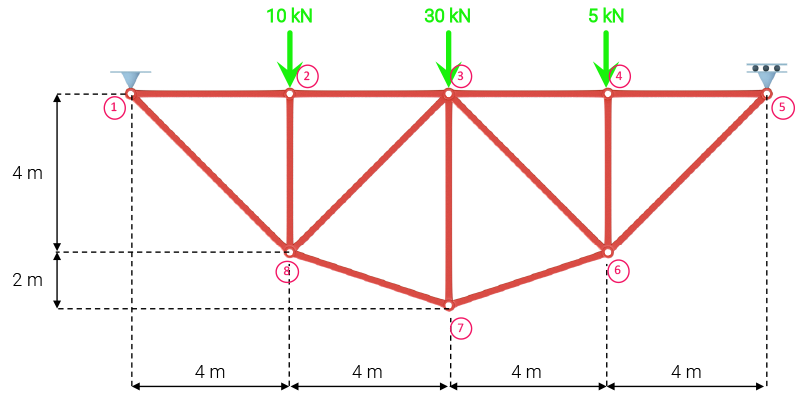

## Structure Data Entry

In [2]:
#Constants
E = 200*10**9 #(N/m^2)
A = 0.005 #(m^2)

#Nodal coordinates [x, y] (in ascending node order)
nodes = np.array([[0,6],
                  [4,6],
                  [8,6],
                  [12,6],
                  [16,6],
                  [12,2],           
                  [8,0],
                  [4,2]
                 ])

#Members [node_i, node_j]
members = np.array([[1,2],
                   [2,3],
                   [3,4],
                   [4,5],
                   [5,6],
                   [6,7],
                   [7,8],
                   [1,8],
                   [2,8],
                   [3,7],
                   [4,6],
                   [3,8],
                   [3,6]
                   ])

## Plot structure to confirm before proceeding

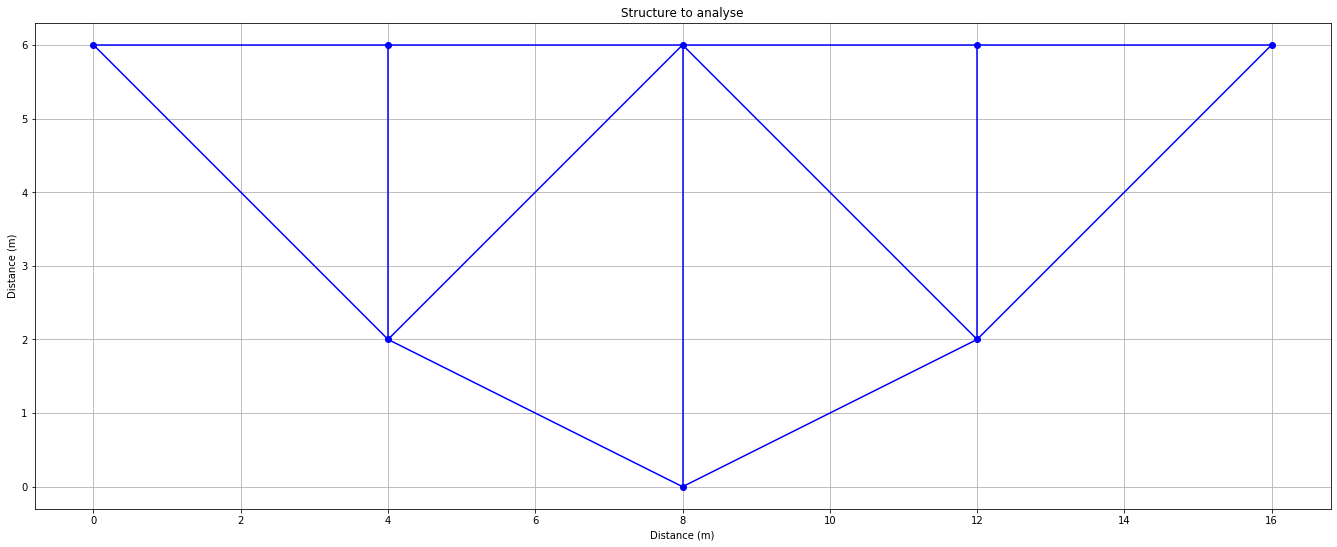

In [3]:
fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,3,3]) 
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:  
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member   
    
    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member
        
    axes.plot([ix,jx],[iy,jy],'b') #Member
    
#Plot nodes
for n in nodes:
    axes.plot([n[0]],[n[1]],'bo') 

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Structure to analyse')
axes.grid()
plt.show()

### OpenSees - Initialisation

In [4]:
# Remove any existing model
wipe()

# Set the modelbuilder - 2 dimensions and 2 degrees of freedom per node
model('basic', '-ndm', 2, '-ndf', 2)

## OpenSees - Model Definition

### Node definition

In [5]:
for i, n in enumerate(nodes):
    node(i+1, float(n[0]), float(n[1]))
    print(f'Node {i+1} defined')

Node 1 defined
Node 2 defined
Node 3 defined
Node 4 defined
Node 5 defined
Node 6 defined
Node 7 defined
Node 8 defined


### Element definition

In [6]:
#Define a new uniaxial material (Elastic matID E)
uniaxialMaterial("Elastic", 1, E)
#Define each element
for i, mbr in enumerate(members):
    element("Truss", i+1, int(mbr[0]), int(mbr[1]), A, 1)   
    print(f'Element {i+1} defined')

Element 1 defined
Element 2 defined
Element 3 defined
Element 4 defined
Element 5 defined
Element 6 defined
Element 7 defined
Element 8 defined
Element 9 defined
Element 10 defined
Element 11 defined
Element 12 defined
Element 13 defined


### Boundary condition definition

In [7]:
# Set boundary condition
fix(1,1,1) #Pin at node 1
fix(5,0,1) #Horizontal roller at node 5

## OpenSees - Load Definition

In [8]:
# Create TimeSeries with a tag of 1
timeSeries("Constant", 1)

# Create a plain load pattern associated with the TimeSeries (pattern, patternTag, timeseriesTag)
pattern("Plain", 1, 1)

# Create the nodal load - command: load nodeID xForce yForce
load(2, 0.0, -10000.0)
load(3, 0.0, -30000.0)
load(4, 0.0, -5000.0)

## OpenSees - Analysis

In [9]:
# create SOE
system("BandSPD")

# create DOF number
numberer("RCM")

# create constraint handler
constraints("Plain")

# create integrator
integrator("LoadControl", 1.0)

# create algorithm
algorithm("Linear")

# create analysis object
analysis("Static")

# perform the analysis
analyze(1)

0

## Summary output

### Displacements

In [10]:
print("")
print("NODAL DISPLACEMENTS") 
for i, n in enumerate(nodes):     
    ux = round(nodeDisp(i+1, 1),5) #Horizontal nodal displacement
    uy = round(nodeDisp(i+1, 2),5) #Vertical nodal displacement
    print(f'Node {i+1}: Ux = {ux} m, Uy = {uy}')


NODAL DISPLACEMENTS
Node 1: Ux = 0.0 m, Uy = 0.0
Node 2: Ux = -0.0001 m, Uy = -0.00063
Node 3: Ux = -0.00019 m, Uy = -0.00073
Node 4: Ux = -0.00028 m, Uy = -0.00057
Node 5: Ux = -0.00036 m, Uy = 0.0
Node 6: Ux = -5e-05 m, Uy = -0.00055
Node 7: Ux = -0.00018 m, Uy = -0.00058
Node 8: Ux = -0.00032 m, Uy = -0.00059


### Deflected shape

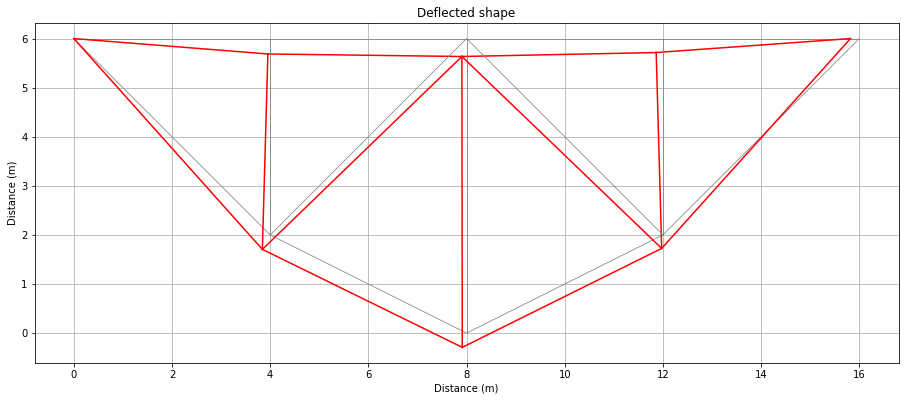

In [11]:
fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,2,2]) 
fig.gca().set_aspect('equal', adjustable='box')

xFac=500

#Plot members
for mbr in members:  
    node_i = int(mbr[0]) #Node number for node i of this member
    node_j = int(mbr[1]) #Node number for node j of this member   
    
    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member
    
    axes.plot([ix,jx],[iy,jy],'grey', lw=0.75) #Member
    
    ux_i = nodeDisp(node_i, 1) #Horizontal nodal displacement
    uy_i = nodeDisp(node_i, 2) #Vertical nodal displacement
    ux_j = nodeDisp(node_j, 1) #Horizontal nodal displacement
    uy_j = nodeDisp(node_j, 2) #Vertical nodal displacement
    
    axes.plot([ix + ux_i*xFac, jx + ux_j*xFac], [iy + uy_i*xFac, jy + uy_j*xFac],'r') #Deformed member
            
axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Deflected shape')
axes.grid()
plt.savefig('my_plot.png', bbox_inches='tight', transparent=True)
plt.show()


### Axial Forces

In [21]:
print("MEMBER FORCES") 
mbrForces = np.array([])
for i, mbr in enumerate(members): 
    axialForce = round(basicForce(i+1)[0]/1000,2)
    mbrForces = np.append(mbrForces,axialForce) #Store axial loads    
    print(f'Force in member {i+1} (nodes {mbr[0]} to {mbr[1]}) is {axialForce} kN')            

MEMBER FORCES
Force in member 1 (nodes 1 to 2) is -23.75 kN
Force in member 2 (nodes 2 to 3) is -23.75 kN
Force in member 3 (nodes 3 to 4) is -21.25 kN
Force in member 4 (nodes 4 to 5) is -21.25 kN
Force in member 5 (nodes 5 to 6) is 30.05 kN
Force in member 6 (nodes 6 to 7) is 27.95 kN
Force in member 7 (nodes 7 to 8) is 27.95 kN
Force in member 8 (nodes 1 to 8) is 33.59 kN
Force in member 9 (nodes 2 to 8) is -10.0 kN
Force in member 10 (nodes 3 to 7) is -25.0 kN
Force in member 11 (nodes 4 to 6) is -5.0 kN
Force in member 12 (nodes 3 to 8) is -1.77 kN
Force in member 13 (nodes 3 to 6) is -5.3 kN


### Plot tension and compression members

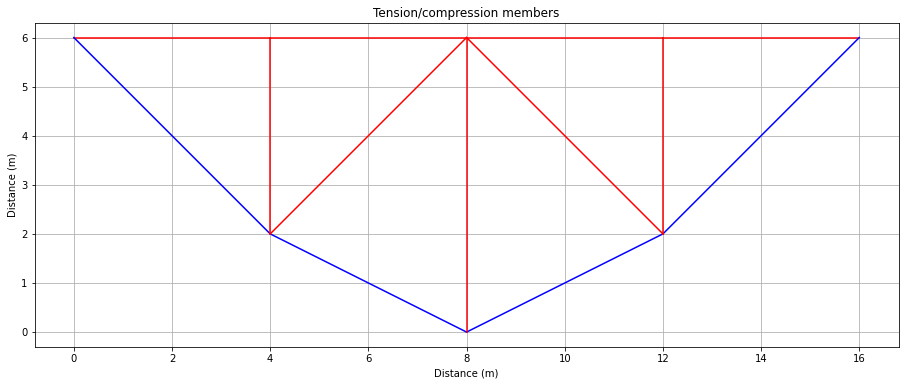

In [22]:
fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,2,2]) 
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for n, mbr in enumerate(members):  
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member   
    
    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member
    
    if(abs(mbrForces[n])<0.001):
        axes.plot([ix,jx],[iy,jy],'grey',linestyle='--') #Zero force in member
    elif(mbrForces[n]>0):
        axes.plot([ix,jx],[iy,jy],'b') #Member in tension
    else:
        axes.plot([ix,jx],[iy,jy],'r') #Member in compression
        
axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Tension/compression members')
axes.grid()
plt.savefig('mbrForces.png', bbox_inches='tight', transparent=True)
plt.show()